NLP Final Project

Wilson Neira

In [2]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('stopwords')
nltk.download('punkt')

# Dataset path
dataset_path = "archive"  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Load emails from folders
def load_emails():
    emails = []
    labels = []
    
    for i in range(1, 7):
        enron_folder = os.path.join(dataset_path, f'enron{i}')
        
        # Spam folder
        spam_folder = os.path.join(enron_folder, 'spam')
        for filename in os.listdir(spam_folder):
            with open(os.path.join(spam_folder, filename), 'r', encoding='latin-1') as f:
                emails.append(f.read())
                labels.append('spam')
        
        # Ham folder
        ham_folder = os.path.join(enron_folder, 'ham')
        for filename in os.listdir(ham_folder):
            with open(os.path.join(ham_folder, filename), 'r', encoding='latin-1') as f:
                emails.append(f.read())
                labels.append('ham')
    
    return emails, labels

# Text preprocessing
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenization
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

# Load and preprocess emails
emails, labels = load_emails()
preprocessed_emails = [preprocess_text(email) for email in emails]

# Convert to DataFrame
df = pd.DataFrame({'email': preprocessed_emails, 'label': labels})

In [4]:

print(sum(label == 'spam'for label in labels))
print(sum(label == 'ham'for label in labels))
print(emails[1])

17170
16545
Subject: your prescription is ready . . oxwq s f e
low cost prescription medications
soma , ultram , adipex , vicodin many more
prescribed online and shipped
overnight to your door ! !
one of our us licensed physicians will write an
fda approved prescription for you and ship your
order overnight via a us licensed pharmacy direct
to your doorstep . . . . fast and secure ! !
click here !
no thanks , please take me off your list
ogrg z
lqlokeolnq
lnu


In [5]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['email'])

# Dimensionality Reduction
svd = TruncatedSVD(n_components=100)
X_reduced = svd.fit_transform(X)

Exploratory Data Analysis

In [30]:
# K-Means Clustering
kmeans = KMeans(n_clusters=6, random_state=42) # 8
kmeans_labels = kmeans.fit_predict(X_reduced)
df['kmeans_cluster'] = kmeans_labels

# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=6) # 6
hierarchical_labels = hierarchical.fit_predict(X_reduced)
df['hierarchical_cluster'] = hierarchical_labels

In [31]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_reduced)
df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]

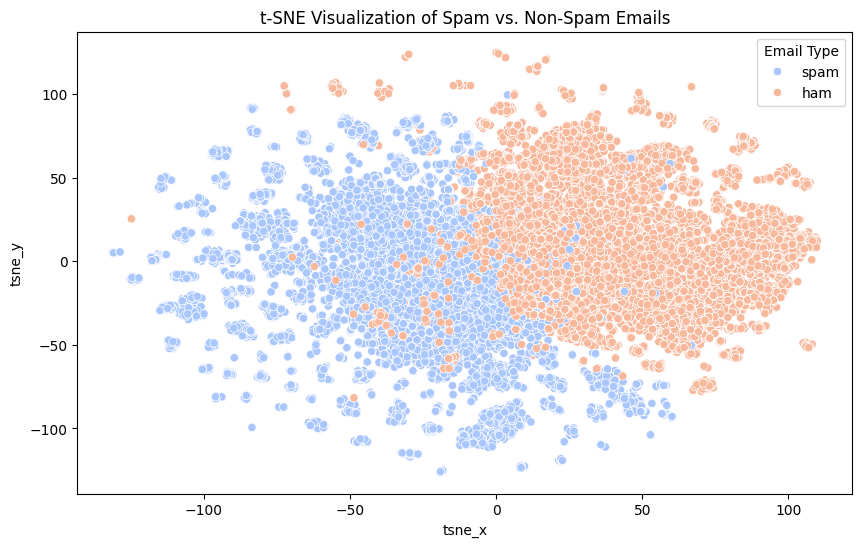

In [32]:
# Visualization using t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_x', y='tsne_y', hue=df['label'], palette='coolwarm', data=df)
plt.title('t-SNE Visualization of Spam vs. Non-Spam Emails')
plt.legend(title="Email Type")
plt.show()

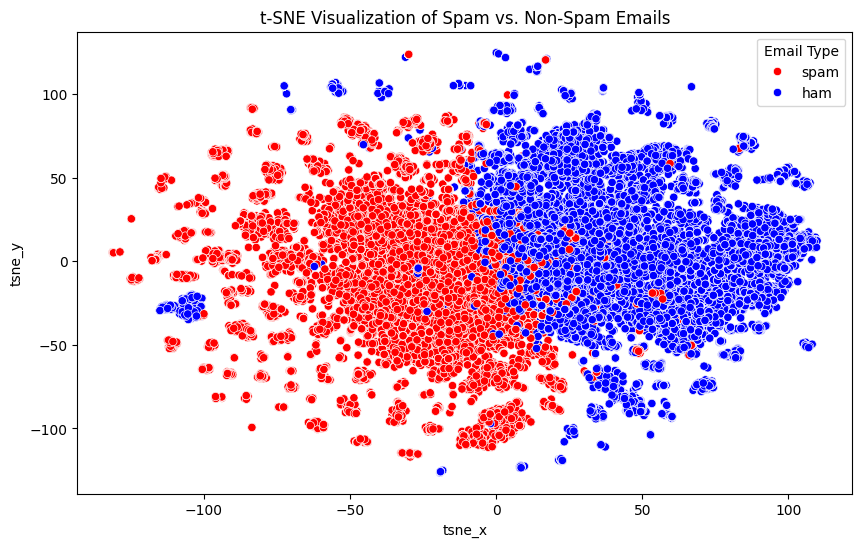

In [33]:
# Visualization using t-SNE
plt.figure(figsize=(10, 6))
cluster_mapping = {0: 'ham', 1: 'spam', 2: 'ham', 3: 'ham', 4: 'spam', 5:'spam'}  

df['predicted_label'] = df['kmeans_cluster'].map(cluster_mapping)
sns.scatterplot(x='tsne_x', y='tsne_y', hue=df['predicted_label'], palette={'spam': 'red', 'ham': 'blue'}, data=df)
plt.title('t-SNE Visualization of Spam vs. Non-Spam Emails')
plt.legend(title="Email Type")
plt.show()

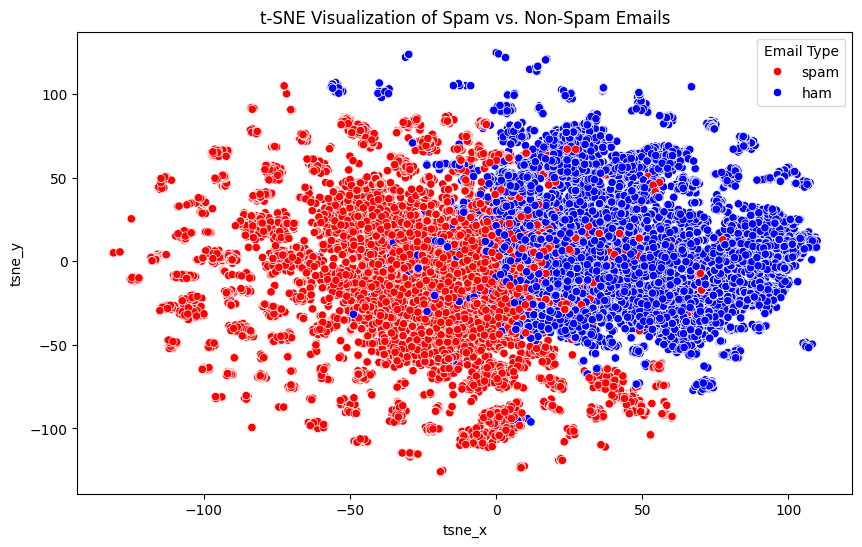

In [42]:
# Visualization using t-SNE
plt.figure(figsize=(10, 6))
cluster_mapping = {0: 'spam', 1: 'ham', 2: 'ham', 3: 'spam', 4: 'ham', 5: 'ham'} 
df['predicted_label'] = df['hierarchical_cluster'].map(cluster_mapping) 
sns.scatterplot(x='tsne_x', y='tsne_y', hue=df['predicted_label'], palette={'spam': 'red', 'ham': 'blue'}, data=df)
plt.title('t-SNE Visualization of Spam vs. Non-Spam Emails')
plt.legend(title="Email Type")
plt.show()

In [ ]:
# Save processed dataset
df.to_csv("processed_emails.csv", index=False)

print("Clustering complete! Processed dataset saved.")

Training and Testing

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score

# Split dataset into training (80%) and testing (20%)
train_emails, test_emails, train_labels, test_labels = train_test_split(
    df['email'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Vectorization (Train on train_emails, transform on test_emails)
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_emails)
X_test = vectorizer.transform(test_emails)  # Use transform instead of fit_transform

# Dimensionality Reduction (Fit on train, transform on test)
svd = TruncatedSVD(n_components=100)
X_train_reduced = svd.fit_transform(X_train)
X_test_reduced = svd.transform(X_test)

In [44]:
# K-Means Clustering (Train on train, Predict on test)
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans_labels_train = kmeans.fit_predict(X_train_reduced)
kmeans_labels_test = kmeans.predict(X_test_reduced)  # Predict clusters for test data

# Hierarchical Clustering (Train on train, Predict on test)
hierarchical = AgglomerativeClustering(n_clusters=6)
hierarchical_labels_train = hierarchical.fit_predict(X_train_reduced)

# Agglomerative Clustering doesn't support '.predict()', so we classify test data using Nearest Centroid
from sklearn.neighbors import NearestCentroid
centroid_classifier = NearestCentroid()
centroid_classifier.fit(X_train_reduced, hierarchical_labels_train)
hierarchical_labels_test = centroid_classifier.predict(X_test_reduced)

In [45]:
# Convert results to DataFrame for evaluation
df_train = pd.DataFrame({'email': train_emails, 'label': train_labels, 
                         'kmeans_cluster': kmeans_labels_train, 'hierarchical_cluster': hierarchical_labels_train})

df_test = pd.DataFrame({'email': test_emails, 'label': test_labels, 
                        'kmeans_cluster': kmeans_labels_test, 'hierarchical_cluster': hierarchical_labels_test})

# Evaluate clustering performance using Adjusted Rand Index (ARI)
ari_kmeans = adjusted_rand_score(test_labels, kmeans_labels_test)
ari_hierarchical = adjusted_rand_score(test_labels, hierarchical_labels_test)

print(f"K-Means ARI Score: {ari_kmeans:.4f}")
print(f"Hierarchical ARI Score: {ari_hierarchical:.4f}")

K-Means ARI Score: 0.0302
Hierarchical ARI Score: 0.0284


In [47]:
# Apply t-SNE on the test set for visualization
tsne = TSNE(n_components=2, random_state=42)
X_test_tsne = tsne.fit_transform(X_test_reduced)

# Add t-SNE results to the test DataFrame
df_test['tsne_x'] = X_test_tsne[:, 0]
df_test['tsne_y'] = X_test_tsne[:, 1]

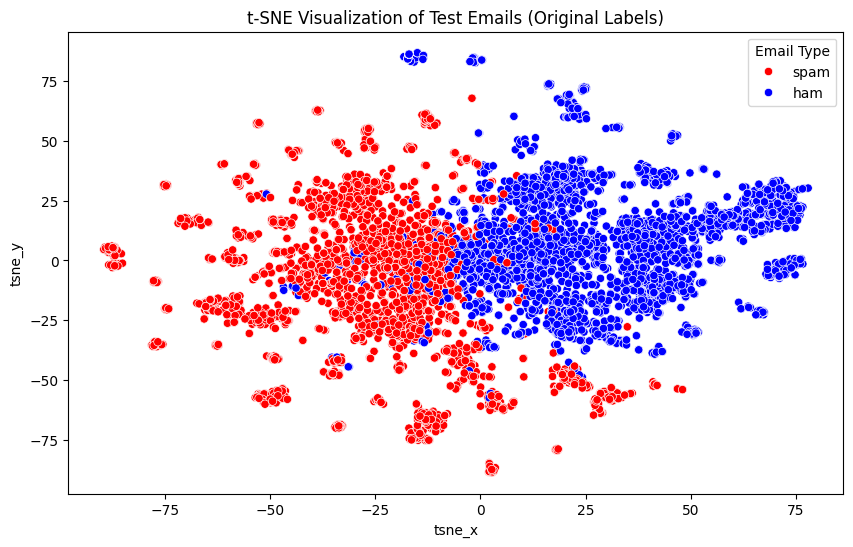

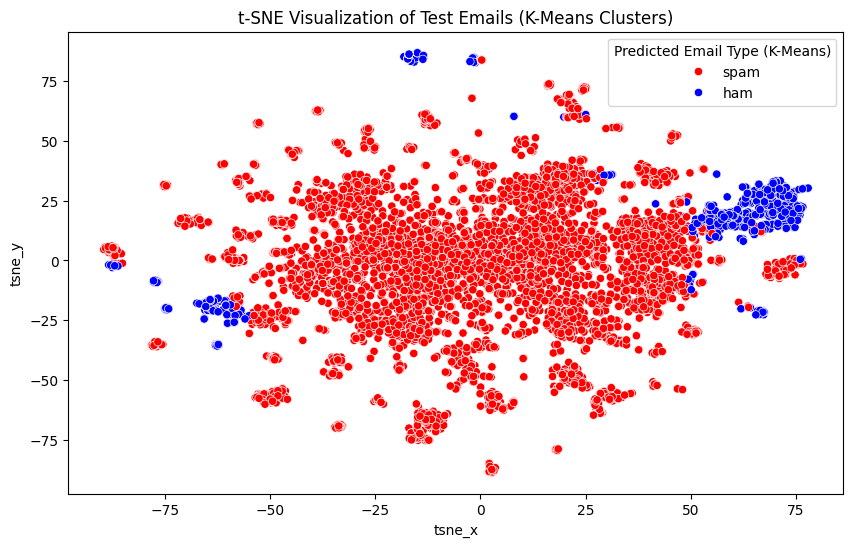

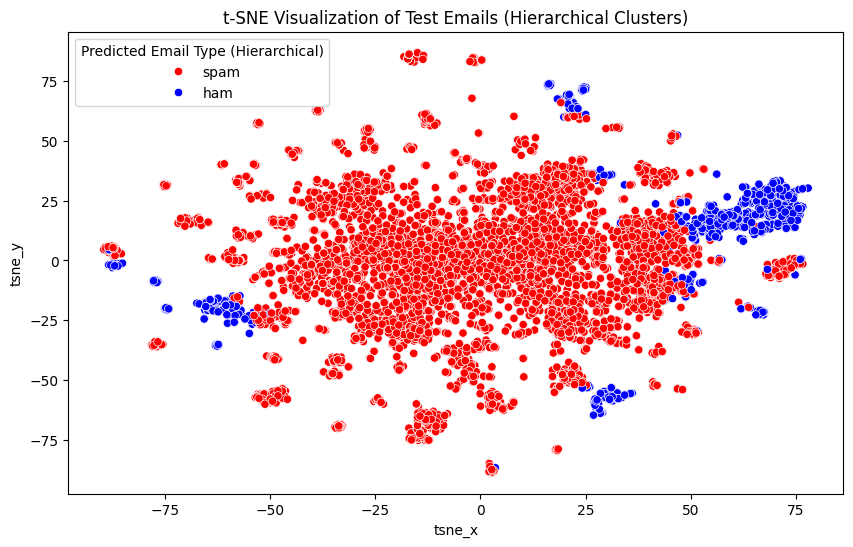

In [ ]:
# Color mappings for plots
color_palette = {'spam': 'red', 'ham': 'blue'}

# Plot t-SNE visualization for original labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_x', y='tsne_y', hue=df_test['label'], palette=color_palette, data=df_test)
plt.title('t-SNE Visualization of Test Emails (Original Labels)')
plt.legend(title="Email Type")
plt.show()

# Cluster mappings for visualization (manual adjustments may be needed based on cluster meaning)
cluster_mapping_kmeans = {0: 'ham', 1: 'spam', 2: 'ham', 3: 'ham', 4: 'spam', 5: 'spam'}
cluster_mapping_hierarchical = {0: 'spam', 1: 'ham', 2: 'ham', 3: 'spam', 4: 'ham', 5: 'ham'}

# Apply cluster mappings
df_test['kmeans_predicted_label'] = df_test['kmeans_cluster'].map(cluster_mapping_kmeans)
df_test['hierarchical_predicted_label'] = df_test['hierarchical_cluster'].map(cluster_mapping_hierarchical)

# t-SNE visualization for K-Means clustered labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_x', y='tsne_y', hue=df_test['kmeans_predicted_label'], palette=color_palette, data=df_test)
plt.title('t-SNE Visualization of Test Emails (K-Means Clusters)')
plt.legend(title="Predicted Email Type (K-Means)")
plt.show()

# t-SNE visualization for Hierarchical clustered labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_x', y='tsne_y', hue=df_test['hierarchical_predicted_label'], palette=color_palette, data=df_test)
plt.title('t-SNE Visualization of Test Emails (Hierarchical Clusters)')
plt.legend(title="Predicted Email Type (Hierarchical)")
plt.show()

In [ ]:
# Save processed train and test datasets
df_train.to_csv("processed_train_emails.csv", index=False)
df_test.to_csv("processed_test_emails.csv", index=False)

print("Training and testing split complete! Processed datasets saved.")